In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import gc

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from General import *
from ReadingTheDataUtils import *
from Classifiers import *
from PreproccesUtils import *
from PerformanceEvalutionUtils import *

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

2019-12-30 13:11:04,278 - DEBUG - MainThread - Classifiers - <module> - First time initialize logger!


In [3]:
from pathlib import Path

ROOT_PATH = Path('..')
SRC_PATH = Path('.')
DATA_PATH = ROOT_PATH / 'data'
CSV_PATH = DATA_PATH / 'ExtraSensory.per_uuid_features_labels'
CSV_SUFFIX = '.features_labels.csv'
ORIGINAL_LABLES_CSV_PATH = DATA_PATH / 'ExtraSensory.per_uuid_original_labels'
ORIGINAL_LABLES_CSV_SUFFIX = '.original_labels.csv'
FOLD_PATH = DATA_PATH / 'cv_5_folds'

In [4]:
%%time
data = pd.read_csv(DATA_PATH / 'dataset.csv', index_col='uuid')

Wall time: 9.09 s


In [5]:
data['label'] = data['label'].astype('category')

for col in data.columns:
    if col.startswith('discrete'):
        data[col] = data[col].astype('category')

In [6]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 377346 entries, 00EABED2-271D-49D8-B599-1D4A09240601 to FDAA70A1-42A3-4E3F-9AE3-3FDA412E03BF
Data columns (total 228 columns):
raw_acc:magnitude_stats:mean                                               377056 non-null float64
raw_acc:magnitude_stats:std                                                377056 non-null float64
raw_acc:magnitude_stats:moment3                                            377056 non-null float64
raw_acc:magnitude_stats:moment4                                            377056 non-null float64
raw_acc:magnitude_stats:percentile25                                       377056 non-null float64
raw_acc:magnitude_stats:percentile50                                       377056 non-null float64
raw_acc:magnitude_stats:percentile75                                       377056 non-null float64
raw_acc:magnitude_stats:value_entropy                                      377056 non-null float64
raw_acc:magnitude_stats:time_entropy

In [7]:
train_folds_list, test_folds_list = get_folds_list(FOLD_PATH)

### Split to train and test

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from MixedColumnTransformer import MixedColumnTransformer, ColumnTypeEnum

from GaussianAndBernoulliNB import GaussianAndBernoulliNB
from sklearn.naive_bayes import BernoulliNB, GaussianNB



def get_pre_pipe():
    transormers = [
        ('ohe', OneHotEncoder(sparse=False), ColumnTypeEnum.CATEGORY),
        ('scaler', StandardScaler(), ColumnTypeEnum.NUMERIC),
        ('SimpleImputerCat', SimpleImputer(strategy="most_frequent"), ColumnTypeEnum.CATEGORY),
        ('SimpleImputerNum', SimpleImputer(strategy='mean'), ColumnTypeEnum.NUMERIC)
    ]
    
    pipe = Pipeline([
        ("mixed_column_transformer", MixedColumnTransformer(transormers))
    ])
    
    return pipe


for train_fold_lst, test_fold_lst in zip(train_folds_list, test_folds_list):
    gc.collect()

    train_fold_df, test_fold_df = get_folds_train_and_test(data, train_fold_lst, test_fold_lst)
    
    X_fold_train, X_fold_test, y_fold_train, y_fold_test = \
            split_fold_data_to_features_and_labels(train_fold_df, test_fold_df)
        
    pipe = get_pre_pipe()
    
    X_train = pipe.fit_transform(X_fold_train)
    y_train = y_fold_train
    X_test = pipe.transform(X_fold_test)
    y_test = y_fold_test
    
    cat_cols_indices = pipe['mixed_column_transformer'].cat_cols_indices_
    num_cols_indices = pipe['mixed_column_transformer'].num_cols_indices_
    
    break

0

### Train

In [9]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from GaussianAndBernoulliNB import GaussianAndBernoulliNB


bernoulli = BernoulliNB()
bernoulli.fit(X_train[:, cat_cols_indices], y_train)

gaussian_bernoulli = GaussianAndBernoulliNB(cat_cols_indices, num_cols_indices)
gaussian_bernoulli.fit(X_train, y_train)

gnb_grid = GaussianNB()
gnb_grid.fit(X_train[:, num_cols_indices], y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

GaussianAndBernoulliNB(bernoulli_params=None,
                       cat_cols_indices=array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]),
                       gaussian_params=None,
                       num_cols_indices=array([ 65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  8...
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       

GaussianNB(priors=None, var_smoothing=1e-09)

# Results

In [10]:
bern_pred = bernoulli.predict(X_test[:, cat_cols_indices])
gaussian_pred = gnb_grid.predict(X_test[:, num_cols_indices])
mixture_pred = gaussian_bernoulli.predict(X_test)

### Compare modle scores

In [11]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [12]:
print(classification_report(y_test, bern_pred))

              precision    recall  f1-score   support

           0       0.24      0.28      0.26     14966
           1       0.04      0.03      0.03      2246
           2       0.01      0.81      0.02       158
           3       0.02      0.64      0.03       187
           4       0.39      0.23      0.29     33630
           5       0.16      0.05      0.08     13872

    accuracy                           0.20     65059
   macro avg       0.14      0.34      0.12     65059
weighted avg       0.29      0.20      0.23     65059



In [13]:
print(classification_report(y_test, gaussian_pred))

              precision    recall  f1-score   support

           0       0.34      0.05      0.09     14966
           1       0.04      0.77      0.07      2246
           2       0.01      0.16      0.01       158
           3       0.03      0.63      0.05       187
           4       0.71      0.15      0.25     33630
           5       0.56      0.09      0.15     13872

    accuracy                           0.14     65059
   macro avg       0.28      0.31      0.11     65059
weighted avg       0.57      0.14      0.19     65059



In [14]:
print(classification_report(y_test, mixture_pred))

              precision    recall  f1-score   support

           0       0.34      0.05      0.09     14966
           1       0.04      0.83      0.08      2246
           2       0.01      0.19      0.01       158
           3       0.03      0.65      0.05       187
           4       0.64      0.17      0.26     33630
           5       0.51      0.11      0.18     13872

    accuracy                           0.15     65059
   macro avg       0.26      0.33      0.11     65059
weighted avg       0.52      0.15      0.20     65059



### Compare model distribution

In [15]:
y_counts = np.bincount(y_test)
bern_counts = np.bincount(bern_pred)
guassian_counts = np.bincount(gaussian_pred)
mixture_counts = np.bincount(mixture_pred)

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

<BarContainer object of 6 artists>

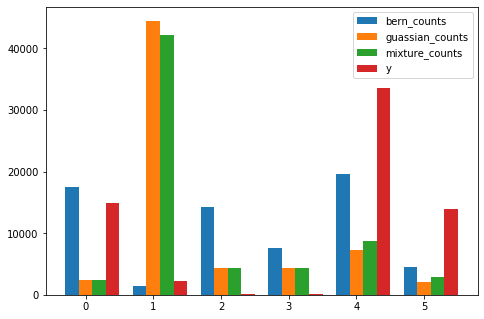

In [16]:
#plot
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

X = np.arange(y_counts.shape[0])

ax.bar(X - 0.20, bern_counts, width=0.20)
ax.bar(X + 0.00, guassian_counts, width=0.20)
ax.bar(X + 0.20, mixture_counts, width=0.20)
ax.bar(X + 0.40, y_counts, width=0.20)

ax.legend(['bern_counts', 'guassian_counts', 'mixture_counts', 'y'])

plt.show()

# Compare model acceptnes

### Feature acceptness

In [67]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.model_selection import GroupKFold

In [55]:
# Get acceptness indices when right!
mixture_and_gaussian_accept = (mixture_pred == gaussian_pred) & (mixture_pred == y_test) & (gaussian_pred == y_test) 
mixture_and_bern_accept = (mixture_pred == bern_pred) & (mixture_pred == y_test) & (bern_pred == y_test) 

In [68]:
# PermutationImportance params
# TODO: add GroupKFold
n_iter  = 10

In [56]:
# Get mixture feature importance
gaussian_bernoulli_perm = PermutationImportance(gaussian_bernoulli, n_iter=n_iter).fit(
    X_test[mixture_and_bern_accept],
    y_test[mixture_and_bern_accept]
)

gaussian_bernoulli_perm_importance = np.argsort(gaussian_bernoulli_perm.feature_importances_)

In [57]:
# Get bernoulli feature importance
bernoulli_perm = PermutationImportance(bernoulli, n_iter=n_iter).fit(
    X_test[mixture_and_bern_accept][:, cat_cols_indices],
    y_test[mixture_and_bern_accept]
)

bernulli_rank = np.argsort(bernoulli_perm.feature_importances_)

In [58]:
# Calc cat indices rank
gaussian_bernoulli_cat_rank = []
mixture_bernoulli_ranking_dict = dict()

for i in cat_cols_indices:
    gaussian_bernoulli_cat_rank.append(np.argwhere(i == gaussian_bernoulli_perm_importance)[0][0])
    
gaussian_bernoulli_cat_rank = np.argsort(gaussian_bernoulli_cat_rank)

for i in bernulli_rank:
    mixture_bernoulli_ranking_dict[i] = [
        np.argwhere(i == bernulli_rank)[0][0],
        np.argwhere(i == gaussian_bernoulli_cat_rank)[0][0]
    ]

In [59]:
# Get gaussian feature importance
gnb_grid_perm = PermutationImportance(gnb_grid, n_iter=n_iter).fit(
    X_test[mixture_and_gaussian_accept][:, num_cols_indices],
    y_test[mixture_and_gaussian_accept]
)

gnb_grid_rank = np.argsort(gnb_grid_perm.feature_importances_)

In [60]:
# Calc numeric indices rank
gaussian_bernoulli_num_rank = []
mixture_gaussian_ranking_dict = dict()


for i in num_cols_indices:
    gaussian_bernoulli_num_rank.append(np.argwhere(i == gaussian_bernoulli_perm_importance)[0][0])
    
gaussian_bernoulli_num_rank = np.argsort(gaussian_bernoulli_num_rank)

for i in gnb_grid_rank:
    mixture_gaussian_ranking_dict[i] = [
        np.argwhere(i == gnb_grid_rank)[0][0],
        np.argwhere(i == gaussian_bernoulli_num_rank)[0][0]
    ]

In [61]:
bernulli_rank
gnb_grid_rank


array([32, 33, 27, 26, 46, 47, 18, 48, 15, 12, 11, 19, 10,  2, 21,  3, 20,
        5, 45,  4, 42, 43, 31, 13, 30, 44, 14, 36,  9, 28, 29, 37,  8, 38,
       39, 51, 52, 49,  1,  0, 50, 24,  6,  7, 25, 40, 41, 60, 59, 54, 62,
       61, 53, 64, 63, 17, 16, 34, 35, 57, 55, 58, 56, 23, 22],
      dtype=int64)

array([ 78,  79,  64,  85,  66,  21,  86,  22,  62,  27,  65, 122,  80,
        74,  53,  63, 123,  18,  29,  54,  97,  55,   2,  73,  28,   3,
        94,  96,  72, 125,  13,  10,  84,  46,  20,  14,  95,  50,  87,
         8,  48,  17,   9,  19, 103,   1, 121,  47,  93,  99,  12,  11,
       124, 115,  61, 110,  81, 105,  42, 100, 111,  24,  51, 120,  15,
       104,  34,  90,  68,  23,  45, 102,  16, 116,  98,  89,  25,  32,
        88,  26,  40,  92,  83,  70, 107,  67, 119,   4, 101,  41, 109,
        31,  35,  33, 106,  75, 108,  91, 114, 112,  36,  76, 113,   6,
        39,  77, 117, 118,  49,  30,   7,   0,  59,  37,   5,  38,  60,
        69,  43,  57,  58,  44,  52,  56,  82,  71], dtype=int64)

In [62]:
gaussian_bernoulli_perm.results_

[array([0.0027137 , 0.00407056, 0.        , 0.        , 0.00407056,
        0.0027137 , 0.00407056, 0.00542741, 0.00678426, 0.0027137 ,
        0.        , 0.        , 0.        , 0.00135685, 0.00135685,
        0.        , 0.00949796, 0.00678426, 0.        , 0.        ,
        0.        , 0.00135685, 0.00135685, 0.0027137 , 0.0339213 ,
        0.02849389, 0.        , 0.        , 0.00135685, 0.00135685,
        0.        , 0.        , 0.        , 0.        , 0.02306649,
        0.02985075, 0.00542741, 0.00407056, 0.        , 0.0027137 ,
        0.00678426, 0.00678426, 0.00135685, 0.0027137 , 0.0027137 ,
        0.00135685, 0.        , 0.        , 0.        , 0.03799186,
        0.03663501, 0.01628223, 0.00949796, 0.00407056, 0.00542741,
        0.02306649, 0.02306649, 0.02035278, 0.01628223, 0.00678426,
        0.00542741, 0.0027137 , 0.00135685, 0.00949796, 0.00949796,
        0.01492537, 0.01628223, 0.01221167, 0.00949796, 0.01085482,
        0.02170963, 0.01628223, 0.01085482, 0.01

In [63]:
pd.DataFrame.from_dict(mixture_bernoulli_ranking_dict, columns=["bernulli", "mixture"], orient='index')

,bernulli,mixture
32,0,13
33,1,11
27,2,5
26,3,1
46,4,12
...,...,...
55,60,58
58,61,54
56,62,57
23,63,30


In [70]:
pd.DataFrame.from_dict(mixture_gaussian_ranking_dict, columns=["gaussian", "mixture"], orient='index')

,gaussian,mixture
78,0,0
79,1,2
64,2,15
85,3,22
66,4,21
...,...,...
44,121,124
52,122,122
56,123,123
82,124,116


In [65]:
gaussian_bernoulli_cat_rank

bernulli_rank

array([47, 26, 48, 19, 18, 27, 12, 11, 10, 15, 31, 33, 46, 32,  2,  3, 20,
       30, 13, 21, 14, 29, 28, 62, 38, 61, 42, 45, 43, 39, 23, 44, 22,  1,
        9,  8,  0, 53, 37, 54, 41, 36,  5,  4, 40, 17,  6,  7, 59, 16, 60,
       63, 64, 52, 58, 51, 57, 56, 55, 34, 35, 25, 24, 49, 50],
      dtype=int64)

array([32, 33, 27, 26, 46, 47, 18, 48, 15, 12, 11, 19, 10,  2, 21,  3, 20,
        5, 45,  4, 42, 43, 31, 13, 30, 44, 14, 36,  9, 28, 29, 37,  8, 38,
       39, 51, 52, 49,  1,  0, 50, 24,  6,  7, 25, 40, 41, 60, 59, 54, 62,
       61, 53, 64, 63, 17, 16, 34, 35, 57, 55, 58, 56, 23, 22],
      dtype=int64)

In [66]:
gaussian_bernoulli_num_rank

gnb_grid_rank

array([ 78,  63,  79,  65,  97,  86,  34,  93,  24,  21,  62,  40,  80,
        22,  29,  64,  50,  28,  17,  81,  27,  66,  85,  23,  74,  94,
        53,  92, 125,  95, 122,  25,  73,  18, 123,  19, 103, 124,  15,
        36, 119,  10,  91, 100,  20, 110,  88,  35,  49, 115,  54,   8,
        48,  84,  12,  72, 111,  46, 121,   3,   7,  14, 114,  45, 109,
        55, 120,  83, 104,  76,  98,   9,  77,   5,   2,   1,  87, 105,
        99,  89,  33,  42,  11,  39,  13,  75,  96,  37,   6, 116,   0,
        61,   4,  67,  51,  68, 117,  47,  90, 108, 101, 118,  60, 113,
       107, 106, 112,  16,  38,  41,  59,  32,  31,  26, 102,  69,  82,
        30,  70,  43,  58,  57,  52,  56,  44,  71], dtype=int64)

array([ 78,  79,  64,  85,  66,  21,  86,  22,  62,  27,  65, 122,  80,
        74,  53,  63, 123,  18,  29,  54,  97,  55,   2,  73,  28,   3,
        94,  96,  72, 125,  13,  10,  84,  46,  20,  14,  95,  50,  87,
         8,  48,  17,   9,  19, 103,   1, 121,  47,  93,  99,  12,  11,
       124, 115,  61, 110,  81, 105,  42, 100, 111,  24,  51, 120,  15,
       104,  34,  90,  68,  23,  45, 102,  16, 116,  98,  89,  25,  32,
        88,  26,  40,  92,  83,  70, 107,  67, 119,   4, 101,  41, 109,
        31,  35,  33, 106,  75, 108,  91, 114, 112,  36,  76, 113,   6,
        39,  77, 117, 118,  49,  30,   7,   0,  59,  37,   5,  38,  60,
        69,  43,  57,  58,  44,  52,  56,  82,  71], dtype=int64)

# =========================

In [28]:
groups = pd.Series(X_fold_train.index).astype('category').cat.codes

In [29]:
from sklearn.model_selection import GroupKFold

gkf = GroupKFold(n_splits=3)

for train_index, test_index in gkf.split(X_fold_train, groups=ser.cat.codes):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_, X_test_ = X_fold_train.iloc[train_index], X_fold_train.iloc[test_index]
    
    for index in np.unique(X_train_.index):
        if index in np.unique(X_test_.index):
            raise Exception("")

NameError: name 'ser' is not defined